# Effective Stiffness of Composite Material


In this section, a demonstration of the MKS homogenization
and localization workflows as shown in Fig. 3 are presented
using PyMKS. Additional workflow examples can be found on
the PyMKS website pymks.org.


In [1]:
import pymks

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Calibration Data Generation

A  set  of  periodic  microstructures  and  their  volume 
averaged  elastic  stress  values $\bar{\sigma}_{xx}$ can
be generated by importing the `make_elastic_stress_random`
function from `pymks.datasets`. This function has several arguments.
`n_samples` is the number of samples that will be generated,
`size` specifices the dimensions of the microstructures.
`grain_size` controls the effective microstructure feature size.
`elastic_modulus` and `poissons_ratio` are used to indicate the 
material property for each of the phases. `macro_strain` is the
value of the applied uniaxial strain, and `seed` can be used
to change the the random number generator seed.

In this homogenization example, 200 samples from six  
different microstructures classes with dimensions 21 x 21
were created totaling 1,200 samples. Each of the six classes have
different microstructure feature sizes. The 
`make_elastic_stress_random` function will return the 
microstructures and their associated volume averaged stress values
which will be used to determine the effective stiffness.

In [138]:
from pymks.datasets import make_elastic_stress_random
import numpy as np

sample_size = 200
grain_size = [(8, 6), (7, 5), (6, 4), 
              (3, 5), (2, 4), (1, 3)]
volume_fraction = [(0.8, 0.2), (0.8, 0.2), (0.8, 0.2),
                   (0.7, 0.3), (0.7, 0.3), (0.7, 0.3)]
percent_variance = 0.15
n_samples = [sample_size] * 6
elastic_modulus = (310, 200)
poissons_ratio = (0.28, 0.3)
macro_strain = 0.001
size = (21, 21)
np.random.seed(0)
seeds = np.random.randint(100, size=(6,))


X, y = [], []
for gs, vf, sam, seed in zip(grain_size, volume_fraction, n_samples, seeds):

    X_0, y_0 = make_elastic_stress_random(n_samples=sam, size=size, 
                                          grain_size=gs,
                                          volume_fraction=vf, 
                                          percent_variance=percent_variance,
                                          elastic_modulus=elastic_modulus, 
                                          poissons_ratio=poissons_ratio, 
                                          macro_strain=macro_strain, seed=seed)
    X.append(X_0)
    y.append(y_0)
    
X = np.concatenate(X)
y = np.concatenate(y)
print(n_samples)
print(size)
print(grain_size)
print(volume_fraction)
print(percent_variance)
print(elastic_modulus)
print(poissons_ratio)
print(macro_strain)


y /= macro_strain

[200, 200, 200, 200, 200, 200]
(21, 21)
[(8, 6), (7, 5), (6, 4), (3, 5), (2, 4), (1, 3)]
[(0.8, 0.2), (0.8, 0.2), (0.8, 0.2), (0.7, 0.3), (0.7, 0.3), (0.7, 0.3)]
0.2
(310, 200)
(0.28, 0.3)
0.001


The microstructures can be visualized by importing
`draw_microstructures`. Below is an instance from 
all six of the classes.

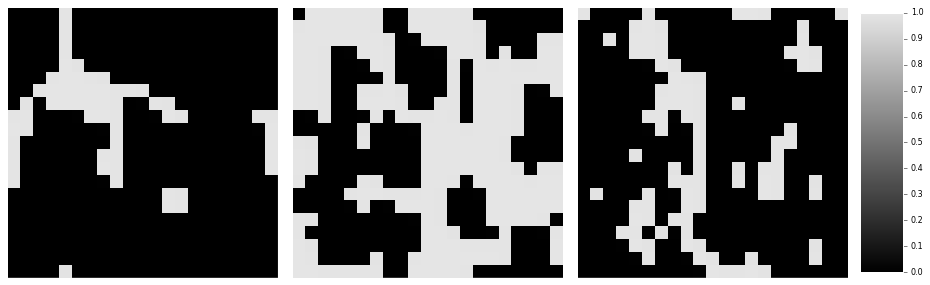

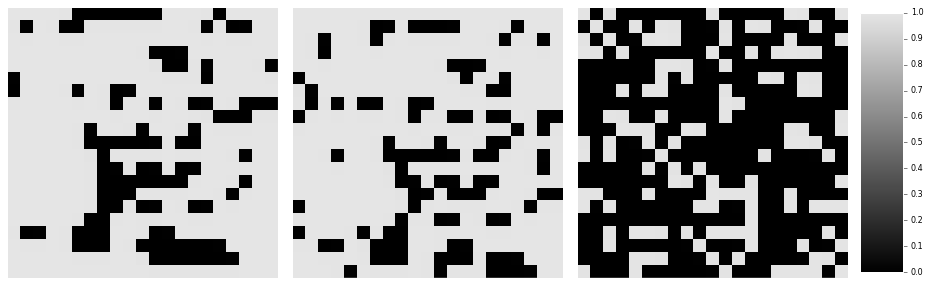

In [139]:
from pymks.tools import draw_microstructures


X_examples = X[1::sample_size]
draw_microstructures(X_examples[:3])
draw_microstructures(X_examples[3:])



## Calibration of Homogenization Model

In order to make an instance of the `MKSHomogenizationModel`,
an instance of a basis class must first be created to specify
the discretization methods for the microstructure function
(see Fig. [ADD_REF]). For this particular example, there are only
2 discrete phases, therefore the `PrimitiveBasis` from
`pymks.bases` will be used. The microstructures contain only
two phases denoted by 0 and 1, therefore we have two local states
and our domain is 0 to 1. An instance of the `PrimitiveBasis`
with these parameters can be used to create an instance of the
`MKSHomgenizationModel` as follows.

In [140]:
from pymks import MKSHomogenizationModel
from pymks import PrimitiveBasis


prim_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
model = MKSHomogenizationModel(basis=prim_basis, periodic_axes=[0, 1], 
                              correlations=[(0, 0), (1, 1)])

The default pipeline used to create the homogenization linkage
contains PCA and polynomial regression objects for Scikit-Learn.
Cross validation is used on the testing data to find the optimal
values (based on the R-squared values) within a defined subspace
for our model parameters using `GridSeachCV` from `sklearn`.
A dictionary `params_to_tune`defines the subspace with a range
for the degrees of the polynomial and the number of principal
components. For this example `n_components` will be varied between
2 to 11 and `degree` of the polynomial regression will be varied
between 1 to 3.

In [164]:
from sklearn.grid_search import GridSearchCV

flat_shape = (X.shape[0],) + (X[0].size,)
params_to_tune = {'degree': np.arange(1,5),
                  'n_components': np.arange(1, 11)}

fit_params = {'size': X[0].shape}
gs = GridSearchCV(model, params_to_tune, cv=10,
                  fit_params=fit_params).fit(X.reshape(flat_shape), y)


The default `score` method for the `MKSHomogenizationModel`
is the value. A visualization of the results from `GridsearchCV`
with he mean R-squared values and their standard deviations
over our search interval can be created using
`draw_gridscores_matrix` from `pymks.tools`.


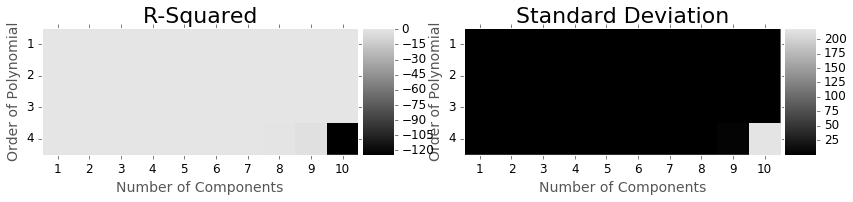

In [165]:
from pymks.tools import draw_gridscores_matrix


draw_gridscores_matrix(gs, ['n_components', 'degree'], score_label='R-Squared',
                       param_labels=['Number of Components', 'Order of Polynomial'])


It looks like we get a poor fit, when only the first and second component are used, and when we increase
the polynomial order and the components together. The models have a high standard deviation and 
poor R-squared values for both of these cases.

There seems to be several potential models that use 4 to 11 components, but it's difficult to see which model 
is the best. Let's use our test data `X_test` to see which model performs the best.


In [166]:
from __future__ import print_function

print('Order of Polynomial', gs.best_estimator_.degree)
print('Number of Components', gs.best_estimator_.n_components)
print('R-squared Value', gs.score(X, y))


Order of Polynomial 4
Number of Components 2
R-squared Value 0.999755606624


For the parameter range that we searched, we have found that a model with 2nd order polynomial 
and 11 components had the best R-squared value. Let's look at the same values, using `draw_grid_scores`.


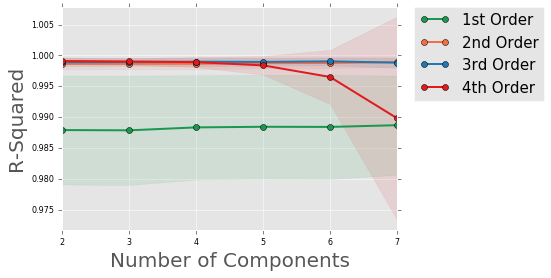

In [167]:
from pymks.tools import draw_gridscores


gs_deg_1 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 1][1:-3]
gs_deg_2 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 2][1:-3]
gs_deg_3 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 3][1:-3]
gs_deg_4 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 4][1:-3]
gs_deg_5 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 5][1:-3]

draw_gridscores([gs_deg_1,  gs_deg_2, gs_deg_3, gs_deg_4],
                'n_components', 
                data_labels=['1st Order', '2nd Order', '3rd Order', '4th Order'],
                param_label='Number of Components', score_label='R-Squared')


As we said, a model with a 2rd order polynomial and 11 components will give us the best result. Let's use the
best model from our grid scores.


In [168]:
model = gs.best_estimator_


## Prediction using MKSHomogenizationModel

Now that we have selected values for `n_components` and `degree`, lets fit the model with the data. Again, because
our microstructures are periodic, we need to use the `periodic_axes` argument.


In [169]:
model.fit(X, y)


Let's generate some more data that can be used to try and validate our model's prediction accuracy. We are going to
generate 20 samples of all six different types of microstructures using the same 
`make_elastic_stress_random` function.


In [170]:
test_sample_size = 20
n_samples = [test_sample_size] * 6

print(n_samples)
print(size)
print(grain_size)
print(volume_fraction)
print(percent_variance)
print(elastic_modulus)
print(poissons_ratio)
print(macro_strain)

seeds = np.random.randint(100, size=(6,))


X_new, y_new = [], []
for gs, vf, sam, seed in zip(grain_size, volume_fraction, n_samples, seeds):

    X_0, y_0 = make_elastic_stress_random(n_samples=sam, size=size, 
                                          grain_size=gs,
                                          volume_fraction=vf, 
                                          percent_variance=percent_variance,
                                          elastic_modulus=elastic_modulus, 
                                          poissons_ratio=poissons_ratio, 
                                          macro_strain=macro_strain, seed=seed)
    X_new.append(X_0)
    y_new.append(y_0)
    
X_new = np.concatenate(X_new)
y_new = np.concatenate(y_new)

y_new /= macro_strain

[20, 20, 20, 20, 20, 20]
(21, 21)
[(8, 6), (7, 5), (6, 4), (3, 5), (2, 4), (1, 3)]
[(0.8, 0.2), (0.8, 0.2), (0.8, 0.2), (0.7, 0.3), (0.7, 0.3), (0.7, 0.3)]
0.2
(310, 200)
(0.28, 0.3)
0.001


IndexError: index 453 is out of bounds for axis 1 with size 441

Now let's predict the stress values for the new microstructures. 


In [ ]:
y_predict = model.predict(X_new)


We can look to see, if the low-dimensional representation of the 
new data is similar to the low-dimensional representation of the data 
we used to fit the model using `draw_components_scatter` from `pymks.tools`.


In [ ]:
from pymks.tools import draw_components_scatter


draw_components_scatter([model.reduced_fit_data[:, :2], 
                         model.reduced_predict_data[:, :2]],
                        ['Training Data', 'Test Data'],
                       legend_outside=True)


The predicted data seems to be reasonably similar to the data we used to fit the model
with. Now let's look at the score value for the predicted data.


In [ ]:
from sklearn.metrics import r2_score
print('R-squared', model.score(X_new, y_new))


Looks pretty good. Let's print out one actual and predicted stress value for each of the 6 microstructure types to see how they compare.


In [ ]:
print('Actual Stress   ', y_new[::20])
print('Predicted Stress', y_predict[::20])


Lastly, we can also evaluate our prediction by looking at a goodness-of-fit plot. We
can do this by importing `draw_goodness_of_fit` from `pymks.tools`.


In [ ]:
from pymks.tools import draw_goodness_of_fit


fit_data = np.array([y, model.predict(X)])
pred_data = np.array([y_new, y_predict])
draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Test Data'])


We can see that the `MKSHomogenizationModel` has created a homogenization linkage for the effective stiffness for the 6 different microstructures and has predicted the average stress values for our new microstructures reasonably well.


## References

[1] Landi, G., S.R. Niezgoda, S.R. Kalidindi, Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).

[2] Çeçen, A., et al. "A data-driven approach to establishing microstructure–property relationships in porous transport layers of polymer electrolyte fuel cells." Journal of Power Sources 245 (2014): 144-153. [doi:10.1016/j.jpowsour.2013.06.100](http://dx.doi.org/10.1016/j.jpowsour.2013.06.100)

[3] Deshpande, P. D., et al. "Application of Statistical and Machine Learning Techniques for Correlating Properties to Composition and Manufacturing Processes of Steels." 2 World Congress on Integrated Computational Materials Engineering. John Wiley & Sons, Inc.  [doi:10.1002/9781118767061.ch25](http://dx.doi.org/10.1002/9781118767061.ch25)
